In [2]:
library(randomForestSRC)
library(CoxHD)
library(Hmisc)
library(gridExtra)
library("survminer")
library(dplyr)
library(stringr)
library(survminer)
library(tidyr)
library(cmprsk)
library(ggrepel)
options(warn=-1)
source("../../../src/tools.R")
source("../../script_figures/tools.R")
library(DT)
library(mstate)
library(dplyr)

# I ) Prepare Training Data from which we are going to make the predictions

In [3]:
df <- read.table('../../clustering/clustering_Final_1/df_final_full_component.tsv')
all_gen <- colnames(df)[c(5:88)]
vect <- apply(X=df[,all_gen],2,FUN=function(x) 100*length(which(x==1))/dim(df)[1])
gen <- colnames(df[,match(names(vect[vect>=2]),names(df))])

all_cyto <- colnames(df)[c(89:158)]
vect <- apply(X=df[,all_cyto],2,FUN=function(x) 100*length(which(x==1))/dim(df)[1])
cyto <- colnames(df[,match(names(vect[vect>=2]),names(df))])       
              
comp <- colnames(df)[170:186]

clin <- colnames(df)[c(159:165)]
demo <- colnames(df)[166:167]
master <- read.table('../../../data/initial_dataset/Master_04_10_2019.csv',sep=",",header=T)
rownames(master) <- master$data_pd
tmp <- merge(df[,c(comp,all_gen,all_cyto,clin,demo,"eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse")],master[,c("os","os_status","RelapseCIStatus","OS_CR","RFSyears")],by=0)
rownames(tmp) <- tmp$Row.names
tmp$patient_id <- tmp$Row.names
              



In [5]:

# New molecular Classification


tmp$molecular_classification <- "none"

tmp[(tmp$full_component_NPM1==1  | tmp$full_component_no_events==1 |tmp$full_component_inv_16==1 | tmp$full_component_t_8_21==1 |
     tmp$full_component_t_15_17==1 | (tmp$full_component_additions==1 & tmp$overlap==0)) & tmp$molecular_classification=="none","molecular_classification"] <- "NEW_favorable"

tmp[(tmp$full_component_chr_splicing_1==1 | tmp$full_component_not_assigned==1) & tmp$molecular_classification=="none" ,"molecular_classification"] <- "NEW_intermediate"
          
tmp[(tmp$full_component_additions==1 | tmp$full_component_TP53_complex==1 | tmp$full_component_chr_splicing_multiple==1  | tmp$full_component_inv_3==1) & tmp$molecular_classification=="none","molecular_classification"] <- "NEW_adverse"      
          
tmp[(tmp$CEBPA_bi==1) & tmp$molecular_classification=="none","molecular_classification"] <- "NEW_favorable"
          
tmp[(tmp$full_component_t_11==1 | tmp$full_component_t_6_9==1 | tmp$full_component_WT1==1 | tmp$full_component_DNMT3A_IDH1_2==1 ) & tmp$molecular_classification=="none" ,"molecular_classification"] <- "NEW_intermediate"
     

#order is important! adverse . then intermediate otherwise we . overlap


tmp[tmp$molecular_classification=="NEW_intermediate" & tmp$ITD==1,"molecular_classification"] <- "NEW_adverse"

tmp[tmp$molecular_classification=="NEW_favorable" & tmp$ITD==1,"molecular_classification"] <- "NEW_intermediate"

tmp$NEW_favorable <-  ifelse(tmp$molecular_classification=="NEW_favorable",1,0)
tmp$NEW_intermediate <-  ifelse(tmp$molecular_classification=="NEW_intermediate",1,0)
tmp$NEW_adverse <-  ifelse(tmp$molecular_classification=="NEW_adverse",1,0)
table(tmp$molecular_classification)

df_w_correlates <- tmp


     NEW_adverse    NEW_favorable NEW_intermediate 
             747              719              659 

In [6]:
# Remove weird cases (11) : we do not know when they have relapsed or CR


tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & is.na(tmp$OS_CR)),]
tmp <- tmp[!(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus) & tmp$os_status==1 & tmp$RFSyears > tmp$OS_CR),]   # you can not relapse from CR  after you die !!!
tmp <- tmp[!(tmp$RFSyears==0 & !is.na(tmp$RFSyears)),]  ### remove when Relapse is exactly 0!


# Handle CR

tmp$CR_stat <- ifelse(is.na(tmp$OS_CR),0,1)
tmp[is.na(tmp$OS_CR),"CR"] <- tmp[is.na(tmp$OS_CR),"os"]
tmp[!is.na(tmp$OS_CR),"CR"]<- tmp[!is.na(tmp$OS_CR),"os"] - tmp[!is.na(tmp$OS_CR),"OS_CR"]

# Handle RFS (relapse from first CR)

tmp$Relapse_stat <- ifelse(tmp$RelapseCIStatus==1 & !is.na(tmp$RelapseCIStatus),1,0)
tmp$Relapse <- tmp$os
tmp[tmp$Relapse_stat==1,"Relapse"] <- tmp[tmp$Relapse_stat==1,"CR"] + tmp[tmp$Relapse_stat==1,"RFSyears"]

tmp$OS <- tmp$os
tmp$OS_stat <- tmp$os_status

tmp$Death_in_CR <- tmp$OS
tmp$Death_in_CR_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

tmp$Death_in_CR <- tmp$OS
tmp$Death_in_CR_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

tmp$Death_in_Relapse <- tmp$OS
tmp$Death_in_Relapse_stat <- ifelse(tmp$CR_stat==1 & tmp$Relapse_stat==1 & tmp$OS_stat==1,1,0 )

tmp$Death_without <- tmp$OS
tmp$Death_without_stat <- ifelse(tmp$CR_stat==0 & tmp$Relapse_stat==0 & tmp$OS_stat==1,1,0 )

In [7]:
data <- tmp[,c("patient_id","CR","Relapse","Death_in_CR","Death_in_Relapse","Death_without","CR_stat","Relapse_stat","Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat",
               c(comp,gen,cyto,clin,demo,"eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse","NEW_favorable","NEW_intermediate","NEW_adverse"))]

In [8]:
tmat_data <- transMat(x = list(c(2,6), c(3, 4), c(5), c(),c(),c()), names = c("Alive", "Alive in CR", "Alive with Relapse", "Death in CR" ,"Death in Relapse", "Death without CR"))

In [9]:
msdata <- msprep(data = data, trans = tmat_data, time = c(NA, "CR", "Relapse",
"Death_in_CR","Death_in_Relapse","Death_without"), status = c(NA, "CR_stat", "Relapse_stat", "Death_in_CR_stat","Death_in_Relapse_stat","Death_without_stat"),
                 keep=c("patient_id",comp,gen,cyto,clin,demo,"eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse","NEW_favorable","NEW_intermediate","NEW_adverse"))

In [10]:
events(msdata)

$Frequencies
                    to
from                 Alive Alive in CR Alive with Relapse Death in CR
  Alive                  0        1464                  0           0
  Alive in CR            0           0                755         182
  Alive with Relapse     0           0                  0           0
  Death in CR            0           0                  0           0
  Death in Relapse       0           0                  0           0
  Death without CR       0           0                  0           0
                    to
from                 Death in Relapse Death without CR no event total entering
  Alive                             0              591       55           2110
  Alive in CR                       0                0      527           1464
  Alive with Relapse              582                0      173            755
  Death in CR                       0                0      182            182
  Death in Relapse                  0                0  

In [11]:
msdata <- expand.covs(msdata, c(comp,gen,cyto,clin,demo,"eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse","NEW_favorable","NEW_intermediate","NEW_adverse"), longnames = FALSE)
expanded_component <- colnames(msdata)[97:181]
expanded_genes <- colnames(msdata)[182:356]
expanded_cytos <- colnames(msdata)[357:456]
expanded_clin <- colnames(msdata)[457:491]
expanded_demo <- colnames(msdata)[492:501]
expanded_eln <- colnames(msdata)[502:516]
expanded_proposal <- colnames(msdata)[517:531]

# Data is ready!

# II) Train the Cox Transition Model on the AML Dataset (2110 Patients)

## We decided to use the components + ITD to which you can add the clinical and demographic data to keep the model very simple but effective.

In [12]:
covariates <- c(demo,clin,comp,"ITD")
form <- "Surv(Tstart, Tstop, status) ~ "
for (co in c(covariates)){
    
    for (sub in c(".1",".2",".3",".4",".5")){
        form <- paste (form,paste(co,sub,sep=""),sep = " + ")
    }
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")

In [13]:
### Get Covariates median
covariates_median <- sapply(df[,c(clin,demo)], FUN=median,)
covariates_median

ahd perf_status   bm_blasts   secondary         wbc          hb 
   1.000000    0.000000   60.000000    1.000000   16.300000    9.299995 
        plt      gender         age 
  57.000000    1.000000   59.181383

# III) Tutorial for  personalized outcome

# User specification 

# Empty Dataframe with Covariates

In [14]:
user_data <- data.frame(covariates = c(demo,clin,comp,"ITD"))
user_data$value <- "Not specified"
rownames(user_data) <- user_data$covariates
user_data$covariates <- NULL
datatable(user_data,options= list(pageLength = 50))


HTML widgets cannot be represented in plain text (need html)

# Covariate Specification

In [15]:
change_covariates <- list(full_component_NPM1=1,ITD=1,age=48)

In [16]:
change_covariate <- list(full_component_NPM1=1,ITD=1,age=48)
user_data[names(change_covariates),"value"] <- as.vector(unlist(change_covariate))
datatable(user_data,options= list(pageLength= 50))

HTML widgets cannot be represented in plain text (need html)

# Prediction Time

# 1) Prepare the data

# Handle not specified values

Rules : 

- For not specified component and ITD :0

- Overlap is 1 if more than one component

- Median for clin and demo not specified 

In [17]:

user_data[user_data$value=="Not specified" & rownames(user_data) %in% c(comp,"ITD") ,"value"] <- 0
user_data[user_data$value=="Not specified" & rownames(user_data) %in% c(clin,demo) ,"value"] <- covariates_median[rownames(user_data)[user_data$value=="Not specified"]]

# Convert to numeric format
###
user_data$value <- as.numeric(user_data$value)
###

comp_to_sum <- comp[comp!="overlap"]   # to check whether or not there is an overlap

user_data[rownames(user_data)=="overlap","value"] <- ifelse(sum(user_data[rownames(user_data) %in% comp_to_sum,"value"])>1,1,0)

datatable(user_data,options= list(pageLength= 50))

HTML widgets cannot be represented in plain text (need html)

In [18]:
proposal_molecular_classification <- function(user_data,way="string"){

    proposal_val <- "none"

    proposal_val <- ifelse(user_data["full_component_NPM1",]==1 | user_data["full_component_no_events",]==1 |
                           user_data["full_component_inv_16",]==1 | user_data["full_component_t_8_21",]==1 |
                           user_data["full_component_t_15_17",]==1 | (user_data["full_component_additions",]==1 & user_data["overlap",]==0) & proposal_val=="none","NEW_favorable",proposal_val)

    proposal_val <- ifelse((user_data["full_component_chr_splicing_1",]==1 | user_data["full_component_not_assigned",]==1) & proposal_val=="none" ,"NEW_intermediate",proposal_val)

    proposal_val <- ifelse((user_data["full_component_additions",]==1 | user_data["full_component_TP53_complex",]==1 | user_data["full_component_chr_splicing_multiple",]==1  | user_data["full_component_inv_3",]==1) & proposal_val=="none" ,"NEW_adverse",proposal_val)


    proposal_val <- ifelse((user_data["full_component_CEBPA_bi",]==1 ) & proposal_val=="none" ,"NEW_favorable",proposal_val)


    proposal_val <- ifelse((user_data["full_component_t_11",]==1 | user_data["full_component_t_6_9",]==1 | user_data["full_component_WT1",]==1 | user_data["full_component_DNMT3A_IDH1_2",]) & proposal_val=="none" ,"NEW_intermediate",proposal_val)

    proposal_val <- ifelse(proposal_val=="NEW_intermediate" & user_data["ITD",]==1,"NEW_adverse",proposal_val)

    proposal_val <- ifelse(proposal_val=="NEW_favorable" & user_data["ITD",]==1,"NEW_intermediate",proposal_val)
    
    if (way=="string"){
        return (proposal_val)
    } else{
        if(proposal_val=="NEW_favorable"){
            return (c(1,0,0))
        }else if(proposal_val=="NEW_intermediate"){
            return (c(0,1,0))
        }else{
            return (c(0,0,1))
        }
    }       
}



# PLOT

In [19]:
dim(df_w_correlates)
cols_component <- colnames(df_w_correlates %>% dplyr:: select(starts_with("full_component_")))

color_values <- c("grey45", "#e79f00", "#009E73","#0072B2",  "#CC79A7","#9ad0f3", "#D55E00", "lightgoldenrod","lightskyblue","#F0E442",
                  "firebrick3","#000000","#870C14","#a6bddb","mistyrose4","#fdbb84","gray","deeppink","darkblue","darkred","darkgreen",
                  "purple","forestgreen")
tmp <- NULL
for (co in cols_component){
    tmp1 <- df_w_correlates[df_w_correlates[,co]==1,]
    tmp1$comparison <- str_remove(co,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }
tmp$fill_pal <- factor(tmp$comparison)
names(color_values) <- levels(factor(tmp$fill_pal))
color_values["overlap"] <- "purple"

colors <- c("black","gray1","gray2",as.vector(unlist(color_values)))



[1] 2125  194

In [66]:
names(colors)

NULL


     _adverse    _favorable _intermediate 
          747           719           659 

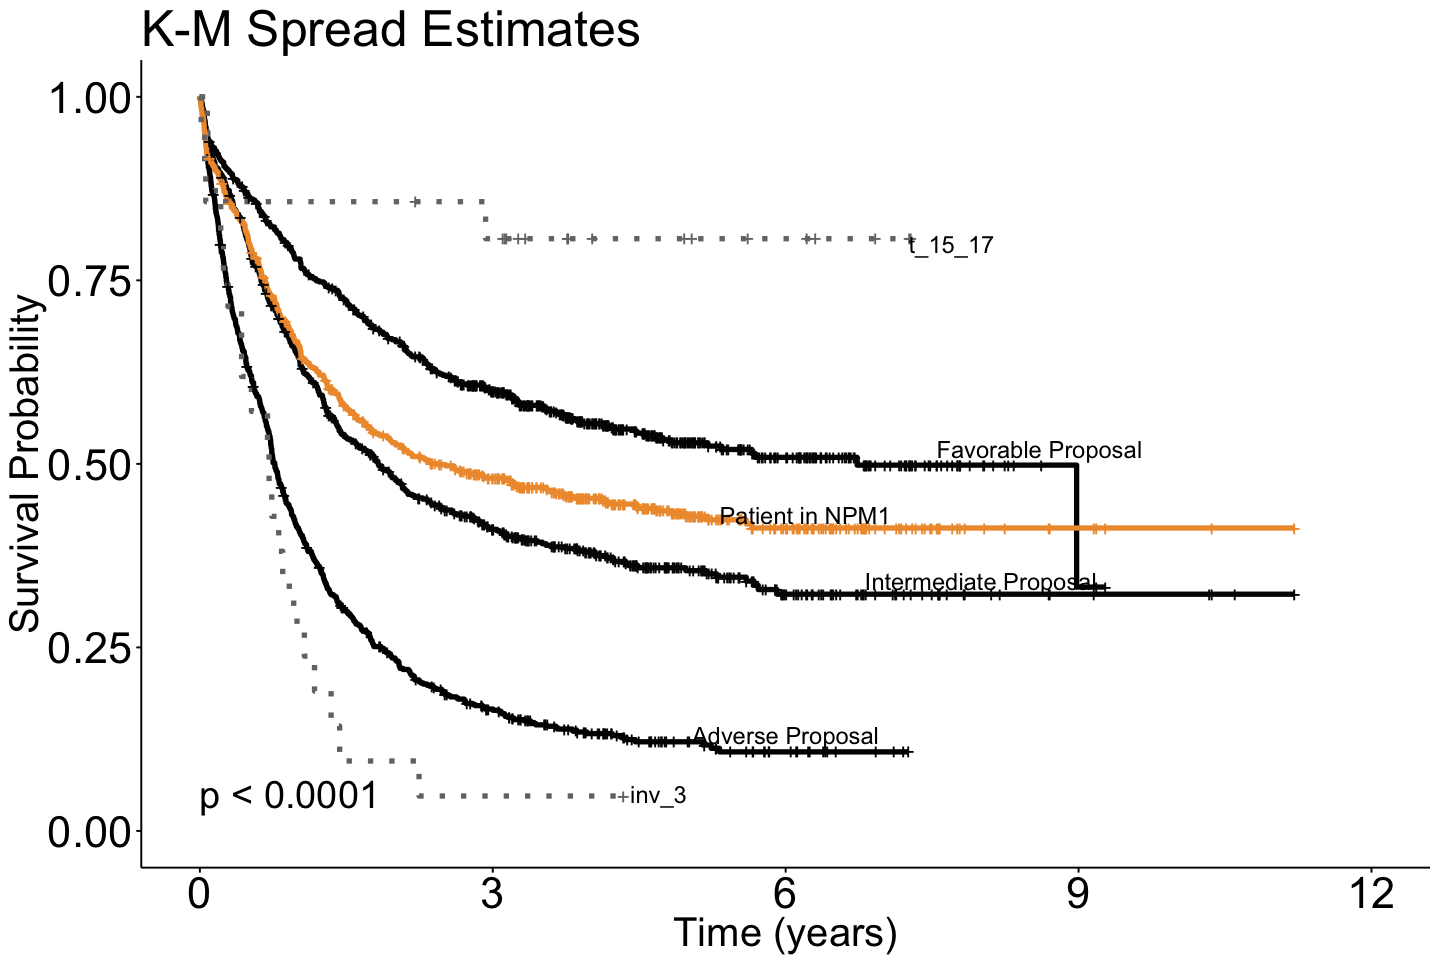

In [95]:

# p$plot + ggplot2::annotate("text", 
#                                 x = c(4.7,5.7,7.7,9,8,6,8,8.6,7.2,7.4,9,7.7), y = c(0.05,0,0.08,0,0.115,0.13,0.34,0.52,0.52,0.66,0.69,0.8),
#                                 label = c("inv_3","t_6_9","TP53_complex","additions","chr_splicing_multiple","Adverse Proposal","Intermediate Proposal",
#                                           "Favorable Proposal","CEBPA_bi","inv_16","t_8_21","t_15_17"), size = 5)

# p$table

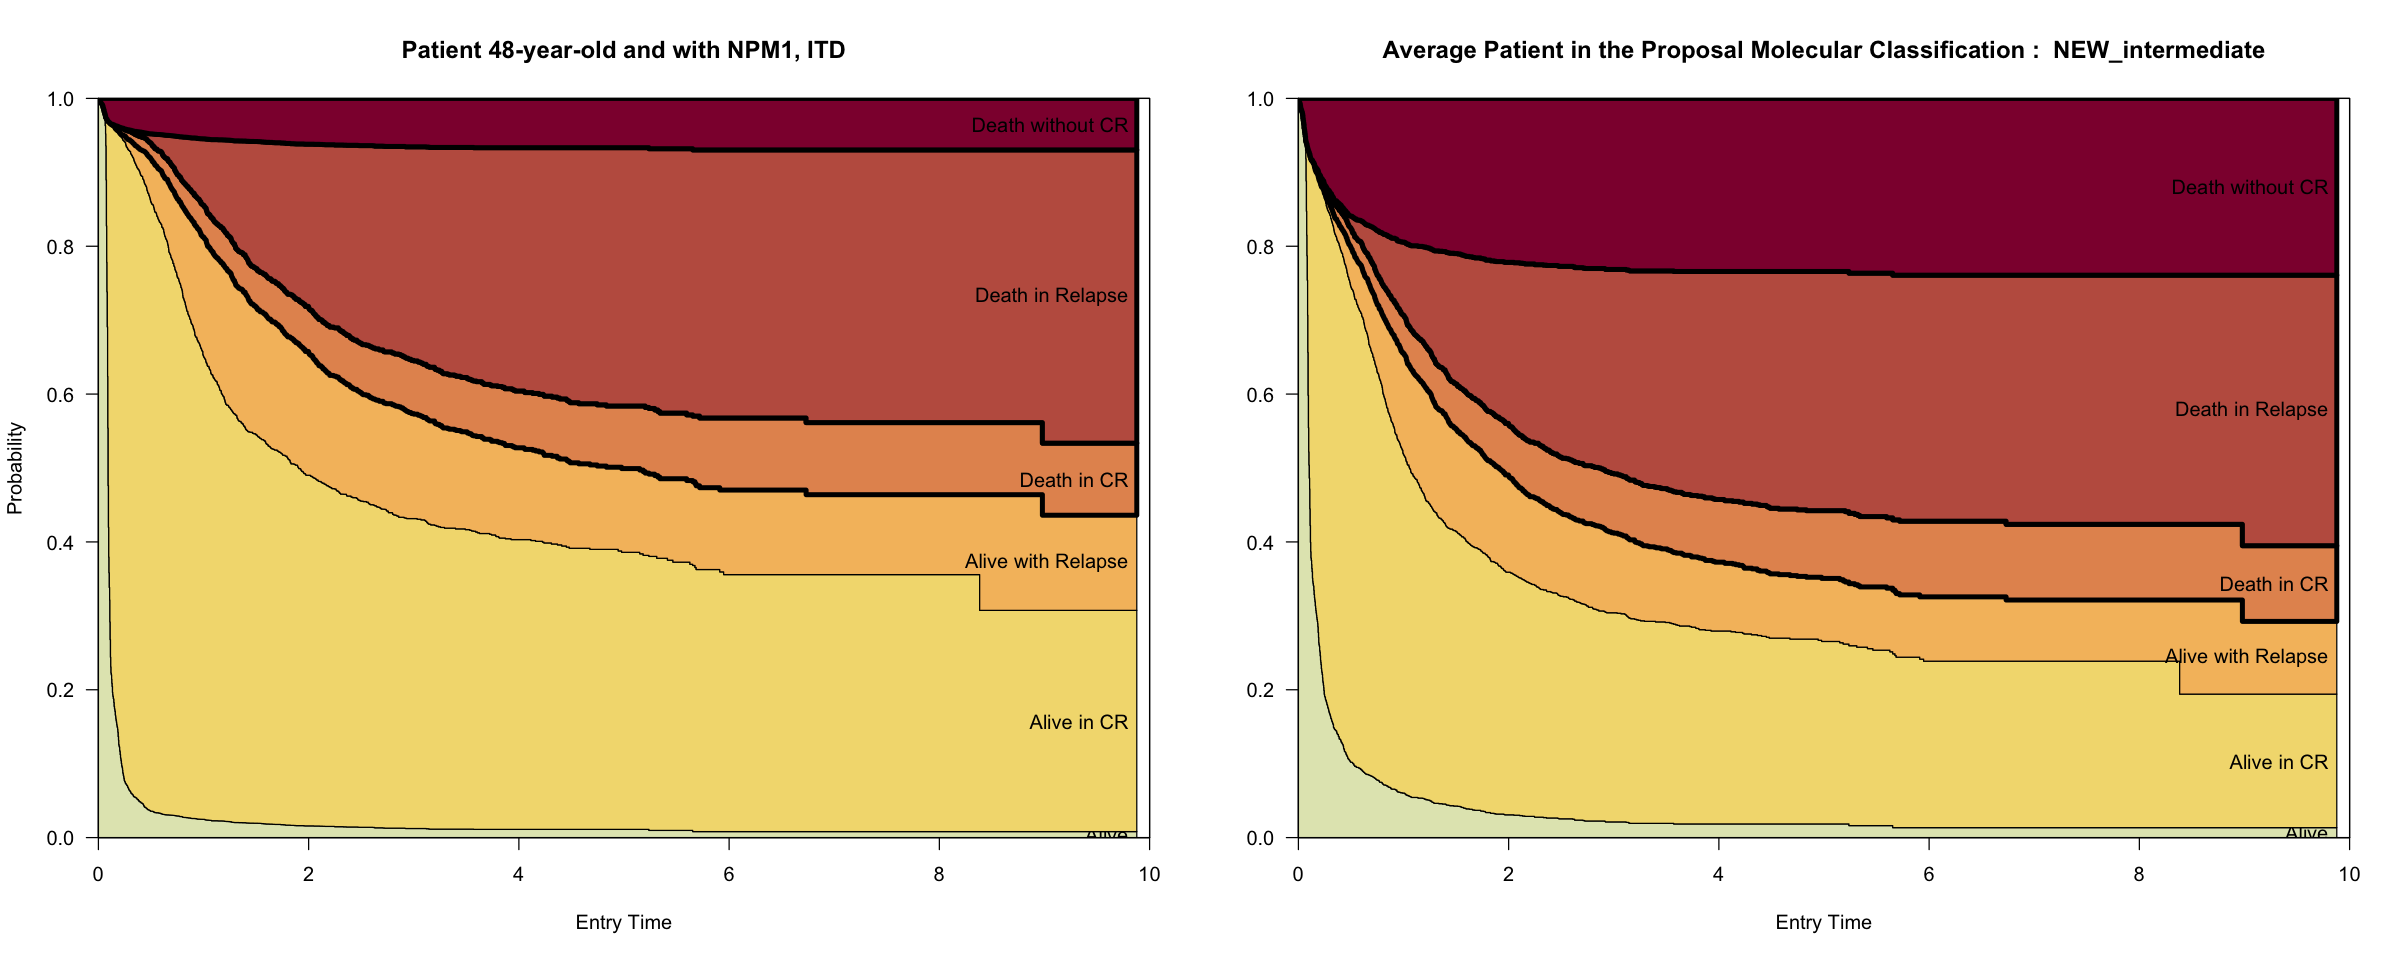

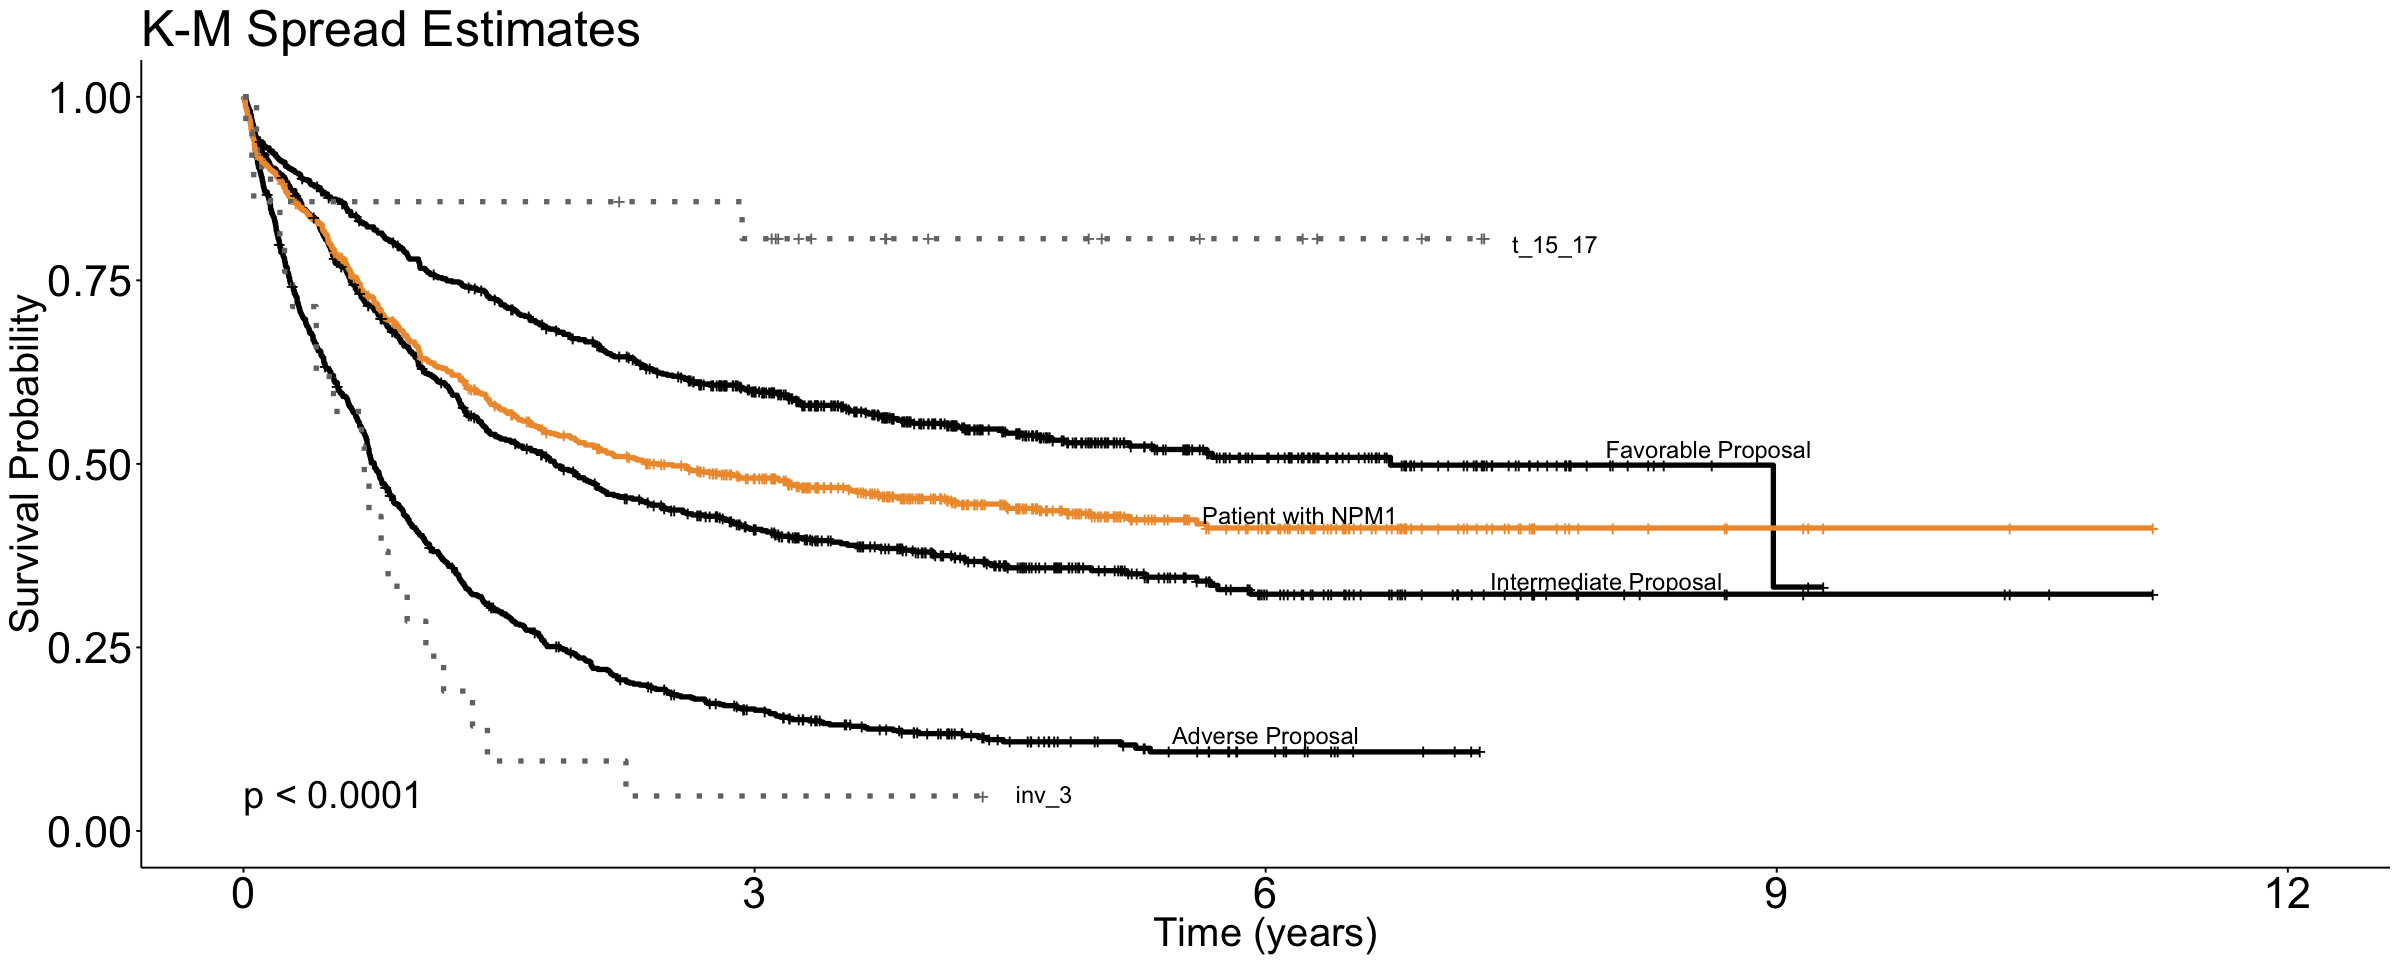

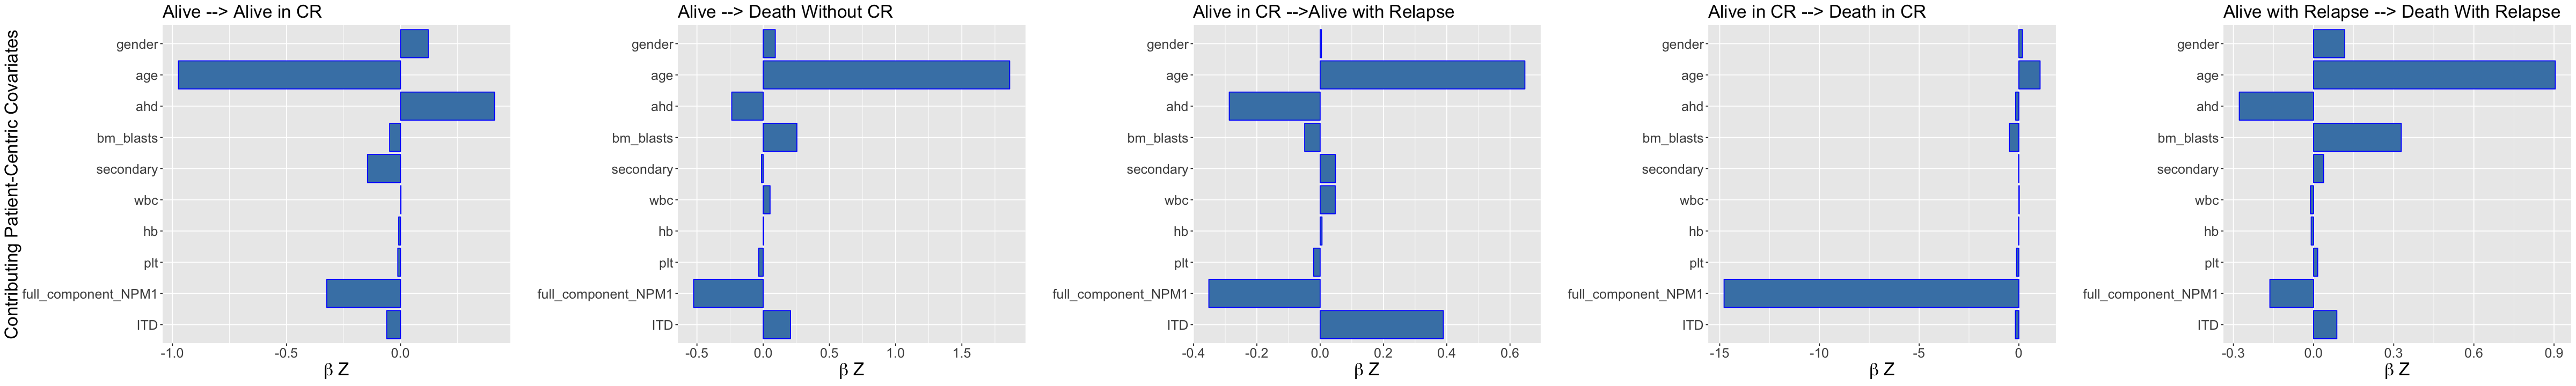

In [127]:
# pdf("tmp_tool.pdf")
set_notebook_plot_size(20,8)
par(mfrow=c(1,2))

tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
tmp_data[nrow(tmp_data),covariates] <- as.numeric(user_data[covariates,])
patA <- tmp_data[rep(nrow(tmp_data),each=5),covariates]
patA$trans <- 1:5
attr(patA, "trans") <- tmat_data

patA <- expand.covs(patA, covariates, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(cfull, patA, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

title_str1<- ifelse("age" %in% names(change_covariates),paste("Patient ","-year-old and with",sep=as.character(change_covariates$age)),"Patient with")
title_str2 <- toString(str_remove(names(change_covariates)[names(change_covariates) %in% c(comp,"ITD")],"full_component_"))
title_str <- paste(title_str1 , title_str2)

plot(ptA, ord = c(1,2,3,4,5,6), main = title_str,
las = 1, xlab = "Entry Time (Years)", xlim = c(0, 10),
type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))


# Plot Proposal Molecular Classification where patient belongs as comparison

form <- "Surv(Tstart, Tstop, status) ~ "
for (co in expanded_proposal){
        form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull_proposal <- coxph(as.formula(form), data = msdata, method = "breslow")

tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
tmp_data[nrow(tmp_data),c("NEW_favorable","NEW_intermediate","NEW_adverse")] <- proposal_molecular_classification(user_data,way="numeric")
patA_proposal <- tmp_data[rep(nrow(tmp_data),each=5),c("NEW_favorable","NEW_intermediate","NEW_adverse")]
patA_proposal$trans <- 1:5
attr(patA_proposal, "trans") <- tmat_data

patA_proposal <- expand.covs(patA_proposal, c("NEW_favorable","NEW_intermediate","NEW_adverse"), longnames = FALSE)
patA_proposal$strata <- patA_proposal$trans
msfA <- msfit(cfull_proposal, patA_proposal, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

plot(ptA, ord = c(1,2,3,4,5,6), main = paste("Average Patient in the Proposal Molecular Classification : ",proposal_molecular_classification(user_data,way="string")),
las = 1, xlab = "Entry Time", xlim = c(0, 10),ylab="",
type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))


# Overall Curve
colors <- c("black","gray1","gray2",as.vector(unlist(color_values)))
colors <- c("black","gray1","gray2","grey45","#EE9937","grey46","green","orange")
tmp <- NULL
extremes <- c("full_component_t_15_17","full_component_inv_3")
# for (col in cols_component){

for (col in c(extremes,"full_component_NPM1")){
    tmp1 <- df_w_correlates[df_w_correlates[,col]==1,]
    tmp1$comparison <- str_remove(col,"full_component_")
    tmp <- rbind(tmp,tmp1)
    }

tmp1 <- df_w_correlates

tmp1$comparison <- str_remove(tmp1$molecular_classification,"NEW")                       
tmp <- rbind(tmp,tmp1)
surv_object <- Surv(time = tmp$os, event = tmp$os_status)
fit <- survfit(surv_object ~ comparison, data = tmp)
p <- plot_surv_curves(fit,submain = "K-M Spread Estimates",vals=colors,linetype=c(1,1,1,3,1,3),size=1.5,y="Survival Probability",legend="none",risk.tab=T,
                     )


set_notebook_plot_size(20,8)

p$plot + ggplot2::annotate("text", 
                                x = c(4.7,6,8,8.6,7.7,6.2), y = c(0.05,0.13,0.34,0.52,0.8,0.43),
                                label = c("inv_3","Adverse Proposal","Intermediate Proposal","Favorable Proposal","t_15_17","Patient with NPM1"), size = 5)

coef_data <- data.frame(summary(cfull)$coefficients)
set_notebook_plot_size(40,6)
p <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    l <- coef_data[endsWith(rownames(coef_data),trans),]
    rownames(l) <- gsub('.{0,2}$', '', rownames(l))

    k <- merge(l,user_data,by=0)
    k["BetaZ"] <- k$coef * k$value
    k <- k %>%slice(match(covariates, Row.names))
    k <- k[k$BetaZ!=0,]
    k
#     k <- k[order(k["BetaZ"],decreasing=T),]
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    xlab <- ifelse(trans==".1","Contributing Patient-Centric Covariates","")
    p[[trans]] <- ggplot(data = k,aes(x = factor(Row.names,level=rev(Row.names)),y= BetaZ)) + geom_bar(stat="identity",colour="blue",fill="steelblue") +coord_flip() + xlab(xlab) + ylab(expression(beta ~ Z)) +ggtitle(title)+
    theme(axis.title=element_text(size=20),axis.text=element_text(size=15),plot.title=element_text(size=20))
    
}
do.call("grid.arrange",c(p,nrow=1))


# dev.off()

In [ ]:
for (trans in c(".1",".2",".3",".4",".5")){
    df <- data.frame(beta = double(),pvalue = double(),Frequency = double())
    for (row in rownames(summary_cox[endsWith(rownames(summary_cox),trans),]))
        df[row,1:3] <- c(summary_cox[row,"coef"],summary_cox[row,5],100*sum(msdata[,row])/dim(msdata)[1])

    df[,"adjusted_pvalue"] <- p.adjust(df$pvalue)
    df[,"-log10(adjusted_pvalue)"] <- -log(p.adjust(df$pvalue),10)
    df["names"] <- rownames(df)
    df$names <- str_remove(substr(df$names,1,nchar(df$names)-2),"full_component_")
    df$Model <- ifelse(df$names %in% gen,"gen",
                      ifelse(df$names %in% cyto,"cyto",
                            ifelse(df$names %in% clin, "clin",
                                  ifelse(df$names %in% demo, "demo",
                                        ifelse(df$names %in% eln, "eln",
                                               ifelse(df$names %in% mrd,"mrd","comp"))))))
#     df$Model <- "comp"
    df$Frequency <- ifelse(df$names %in% clin, 5,
                                  ifelse(df$names %in% demo, 5, df$Frequency))
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))



In [187]:
k

Row.names,coef,exp.coef.,se.coef.,z,Pr...z..,value,BetaZ
age,-2.028188e-02,0.9799224,0.0018278837,-11.0958280,1.314372e-28,48.000000,-0.973530417
ahd,4.119289e-01,1.5097272,0.1363564511,3.0209714,2.519651e-03,1.000000,0.411928942
bm_blasts,-7.937024e-04,0.9992066,0.0011269595,-0.7042865,4.812544e-01,60.000000,-0.047622142
full_component_additions,-7.996538e-01,0.4494845,0.7309823954,-1.0939441,2.739795e-01,0.000000,0.000000000
full_component_CEBPA_bi,-4.855928e-01,0.6153323,0.7350891395,-0.6605903,5.088751e-01,0.000000,0.000000000
full_component_chr_splicing_1,-8.535728e-01,0.4258906,0.7246169839,-1.1779641,2.388109e-01,0.000000,0.000000000
full_component_chr_splicing_multiple,-1.019867e+00,0.3606431,0.7159097712,-1.4245741,1.542804e-01,0.000000,0.000000000
full_component_DNMT3A_IDH1_2,-7.862420e-01,0.4555535,0.7314694981,-1.0748801,2.824284e-01,0.000000,0.000000000
full_component_inv_16,-2.290846e-01,0.7952612,0.7266513219,-0.3152607,7.525637e-01,0.000000,0.000000000
full_component_inv_3,-1.523691e+00,0.2179061,0.7927043034,-1.9221429,5.458778e-02,0.000000,0.000000000


In [201]:
library(dplyr)

# create a vector with letters in the desired order
x <- covariates

k %>%
  slice(match(x, Row.names))

Row.names,coef,exp.coef.,se.coef.,z,Pr...z..,value,BetaZ
gender,0.1167922578,1.1238859,0.0881915301,1.324302432,1.854026e-01,1.000000,0.116792258
age,0.0188483133,1.0190271,0.0031160700,6.048745229,1.459783e-09,48.000000,0.904719036
ahd,-0.2780841552,0.7572331,0.1803148406,-1.542214464,1.230215e-01,1.000000,-0.278084155
perf_status,0.2848316464,1.3295382,0.0630901128,4.514679617,6.341256e-06,0.000000,0.000000000
bm_blasts,0.0054696673,1.0054847,0.0018703687,2.924379178,3.451440e-03,60.000000,0.328180038
secondary,0.0378920495,1.0386191,0.0973300128,0.389315160,6.970430e-01,1.000000,0.037892050
wbc,-0.0007061887,0.9992941,0.0007280576,-0.969962674,3.320651e-01,16.300000,-0.011510876
hb,-0.0009651212,0.9990353,0.0020211759,-0.477504771,6.330027e-01,9.299995,-0.008975622
plt,0.0002733921,1.0002734,0.0003356957,0.814404532,4.154132e-01,57.000000,0.015583348
full_component_t_15_17,-1.9548135124,0.1415909,1.4528467879,-1.345505616,1.784620e-01,0.000000,0.000000000


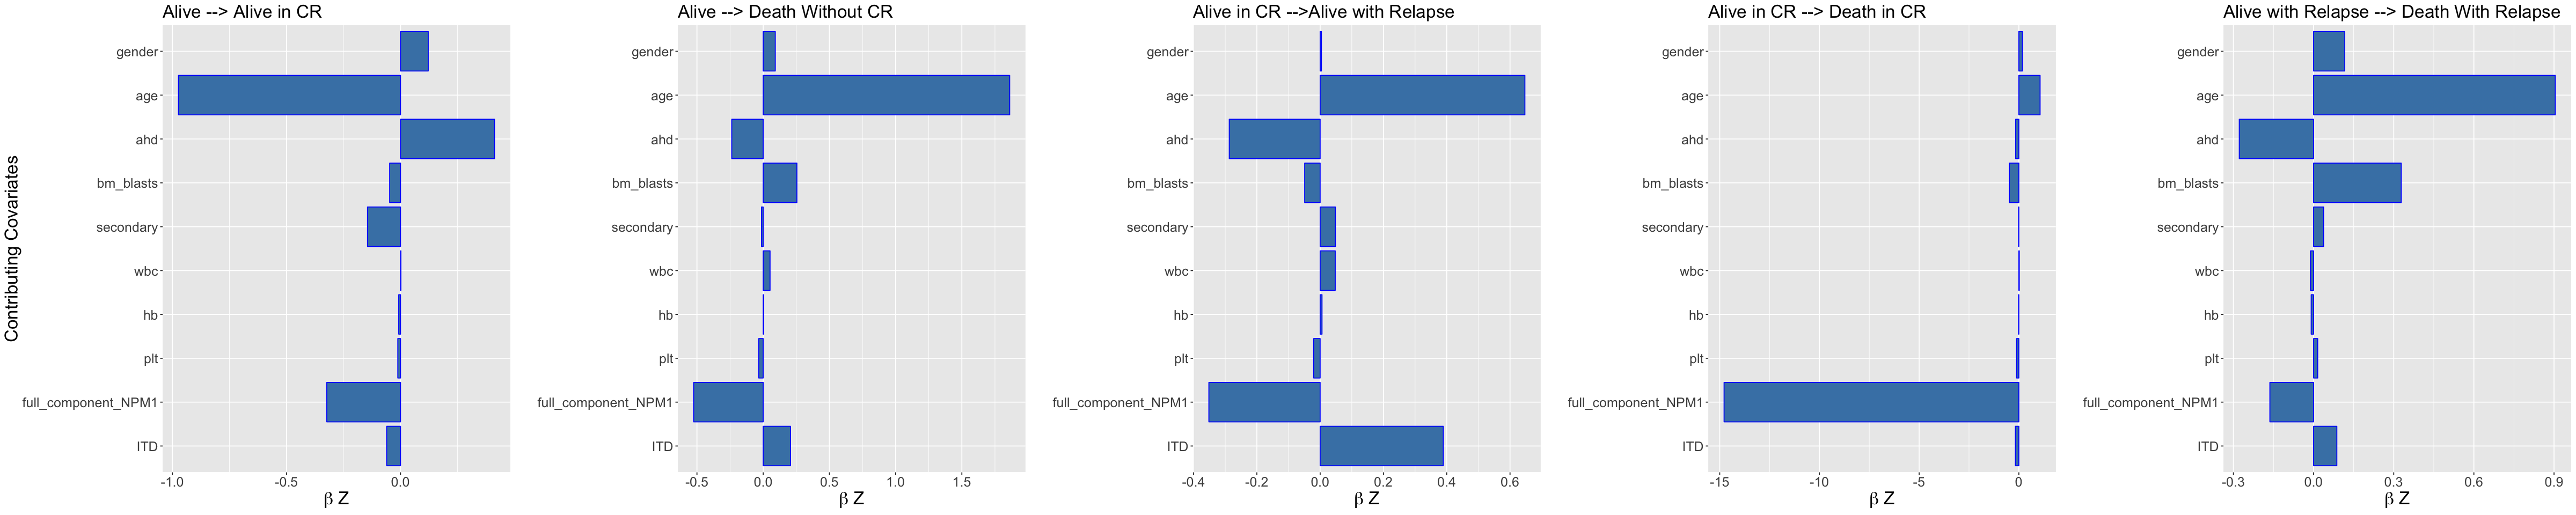

In [221]:
set_notebook_plot_size(40,8)
p <- list()
for (trans in c(".1",".2",".3",".4",".5")){
    l <- coef_data[endsWith(rownames(coef_data),trans),]
    rownames(l) <- gsub('.{0,2}$', '', rownames(l))

    k <- merge(l,user_data,by=0)
    k["BetaZ"] <- k$coef * k$value
    k <- k %>%slice(match(covariates, Row.names))
    k <- k[k$BetaZ!=0,]
    k
#     k <- k[order(k["BetaZ"],decreasing=T),]
    
    title <- ifelse(trans==".1","Alive --> Alive in CR",
                   ifelse(trans==".2","Alive --> Death Without CR",
                         ifelse(trans==".3","Alive in CR -->Alive with Relapse",
                               ifelse(trans==".4","Alive in CR --> Death in CR","Alive with Relapse --> Death With Relapse"))))
    xlab <- ifelse(trans==".1","Contributing Covariates","")
    p[[trans]] <- ggplot(data = k,aes(x = factor(Row.names,level=rev(Row.names)),y= BetaZ)) + geom_bar(stat="identity",colour="blue",fill="steelblue") +coord_flip() + xlab(xlab) + ylab(expression(beta ~ Z)) +ggtitle(title)+
    theme(axis.title=element_text(size=20),axis.text=element_text(size=15),plot.title=element_text(size=20))
    
}
do.call("grid.arrange",c(p,nrow=1))

# ELN - Proposal Comparison

Call:
coxph(formula = as.formula(form), data = msdata, method = "breslow")

                            coef exp(coef) se(coef)      z        p
eln_2017_favorable.1     0.83954   2.31530  0.06214 13.510  < 2e-16
eln_2017_favorable.2    -0.56472   0.56852  0.10121 -5.579 2.41e-08
eln_2017_favorable.3    -0.62808   0.53361  0.08504 -7.386 1.51e-13
eln_2017_favorable.4    -1.06291   0.34545  0.16851 -6.308 2.83e-10
eln_2017_favorable.5    -0.54220   0.58147  0.09972 -5.437 5.42e-08
eln_2017_intermediate.1  0.51711   1.67717  0.07268  7.114 1.12e-12
eln_2017_intermediate.2 -0.47357   0.62277  0.11125 -4.257 2.07e-05
eln_2017_intermediate.3 -0.23652   0.78937  0.09580 -2.469  0.01355
eln_2017_intermediate.4 -0.70658   0.49333  0.19765 -3.575  0.00035
eln_2017_intermediate.5 -0.26832   0.76466  0.10490 -2.558  0.01053
eln_2017_adverse.1            NA        NA  0.00000     NA       NA
eln_2017_adverse.2            NA        NA  0.00000     NA       NA
eln_2017_adverse.3            NA        

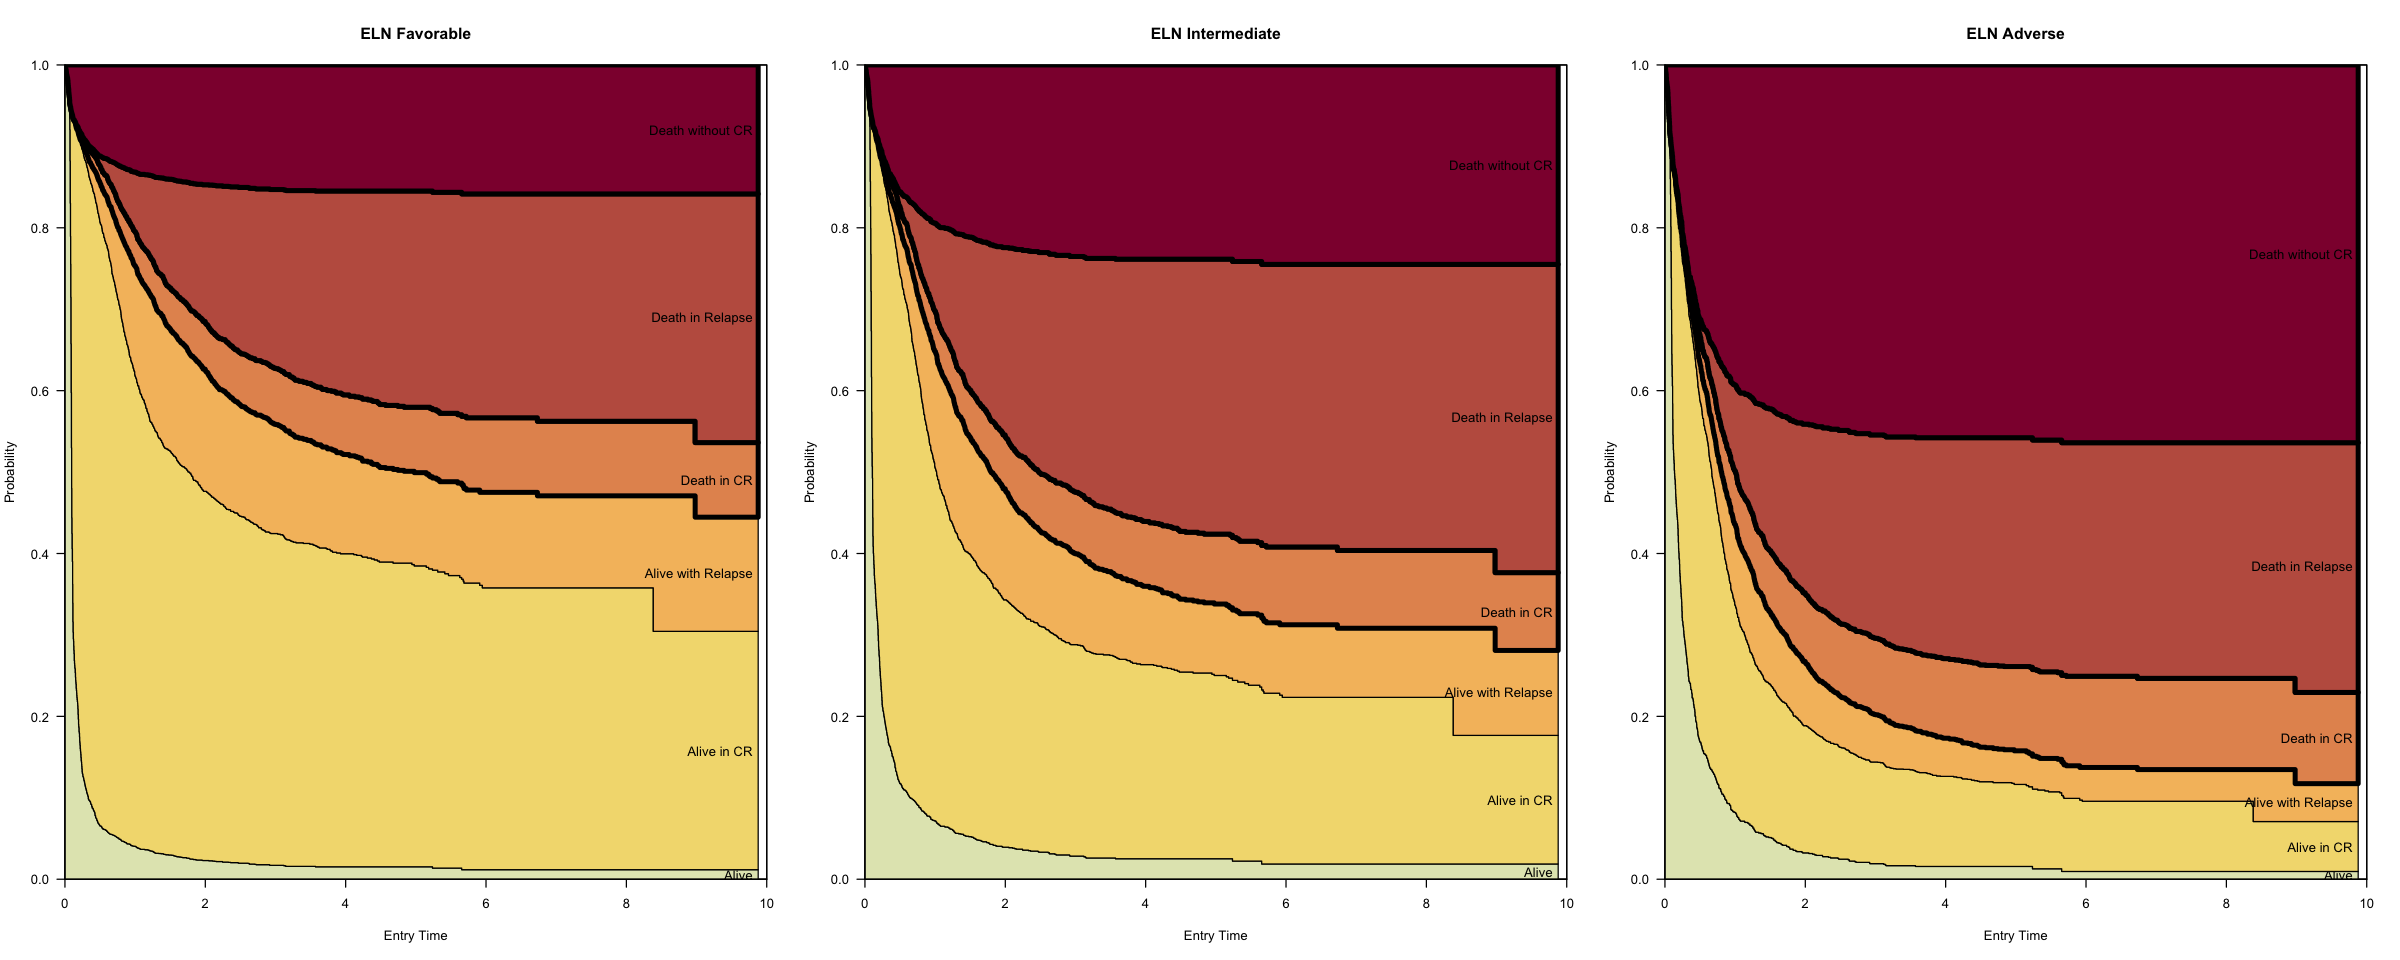

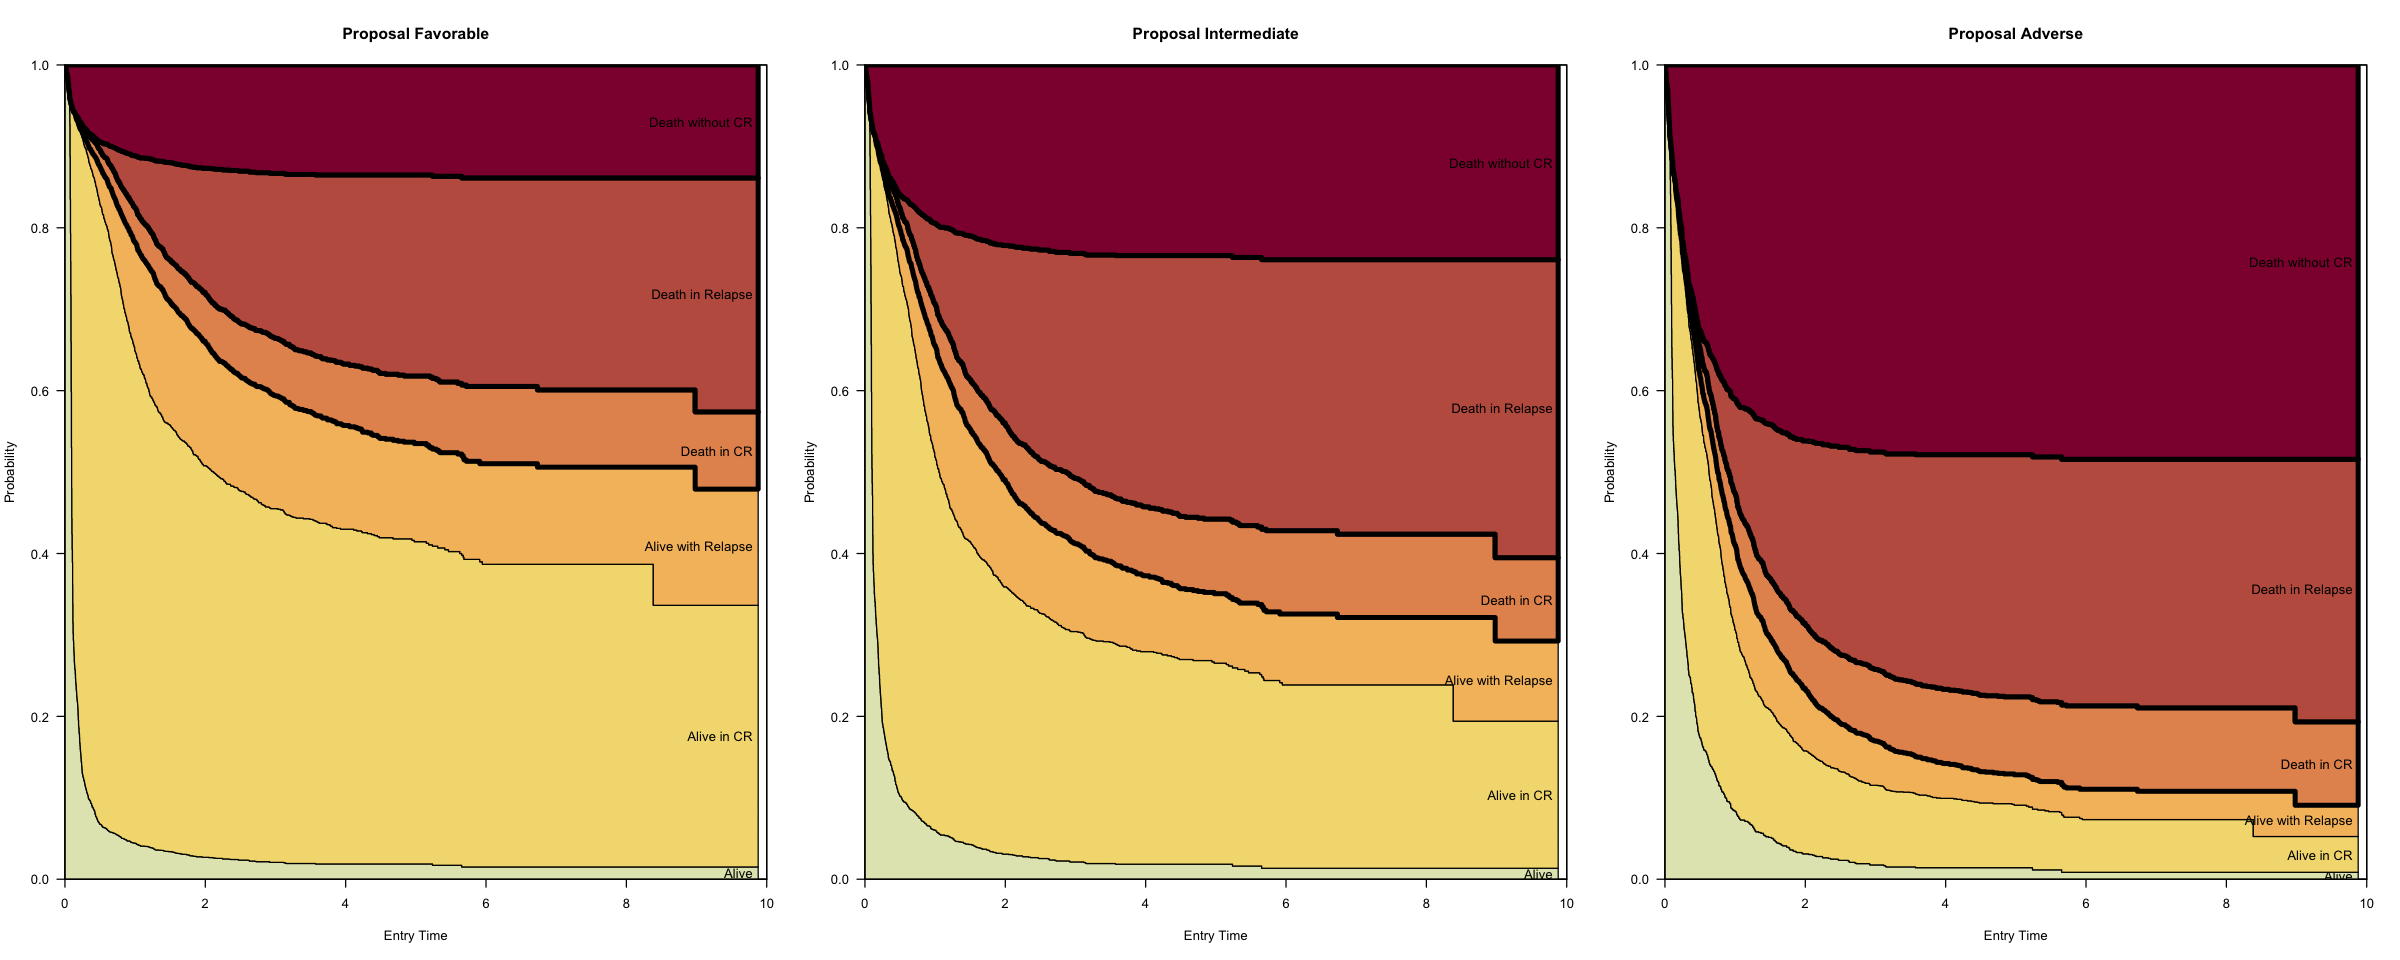

In [493]:
set_notebook_plot_size(20,8)
par(mfrow=c(1,3))

for (i in c(1,2,3)){
    form <- "Surv(Tstart, Tstop, status) ~ "
    for (co in expanded_eln){
        form <- paste (form,co,sep = " + ")
    }
    form <- paste(form,"+ strata(trans)")
    cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
    print(cfull)
    tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
    ifelse(i==1,val <- c(1,0,0),
              ifelse(i==2,val <- c(0,1,0),val <- c(0,0,1)))
    tmp_data[nrow(tmp_data),c("eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse")] <- val
    patA <- tmp_data[rep(nrow(tmp_data),each=5),c("eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse")]
    patA$trans <- 1:5
    attr(patA, "trans") <- tmat_data

    patA <- expand.covs(patA, c("eln_2017_favorable","eln_2017_intermediate","eln_2017_adverse"), longnames = FALSE)
    patA$strata <- patA$trans
    print(patA)
    msfA <- msfit(cfull, patA, trans = tmat_data)

    ptA <- probtrans(msfA, predt = 0)
    ord <- c(1,2,3,4,5,6)

    plot(ptA, ord = c(1,2,3,4,5,6), main = paste("ELN ",ifelse(i==1,"Favorable",ifelse(i==2,"Intermediate","Adverse")),sep=""),
    las = 1, xlab = "Entry Time", xlim = c(0, 10),
    type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
}
for (i in c(1,2,3)){
    form <- "Surv(Tstart, Tstop, status) ~ "
    for (co in expanded_proposal){
        form <- paste (form,co,sep = " + ")
    }
    form <- paste(form,"+ strata(trans)")
    cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
    print(cfull)
    tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
    ifelse(i==1,val <- c(1,0,0),
              ifelse(i==2,val <- c(0,1,0),val <- c(0,0,1)))
    tmp_data[nrow(tmp_data),c("NEW_favorable","NEW_intermediate","NEW_adverse")] <- val
    patA <- tmp_data[rep(nrow(tmp_data),each=5),c("NEW_favorable","NEW_intermediate","NEW_adverse")]
    patA$trans <- 1:5
    attr(patA, "trans") <- tmat_data

    patA <- expand.covs(patA, c("NEW_favorable","NEW_intermediate","NEW_adverse"), longnames = FALSE)
    patA$strata <- patA$trans
    print(patA)
    msfA <- msfit(cfull, patA, trans = tmat_data)

    ptA <- probtrans(msfA, predt = 0)
    ord <- c(1,2,3,4,5,6)

    plot(ptA, ord = c(1,2,3,4,5,6), main = paste("Proposal ",ifelse(i==1,"Favorable",ifelse(i==2,"Intermediate","Adverse")),sep=""),
    las = 1, xlab = "Entry Time", xlim = c(0, 10),
    type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))
}

# END

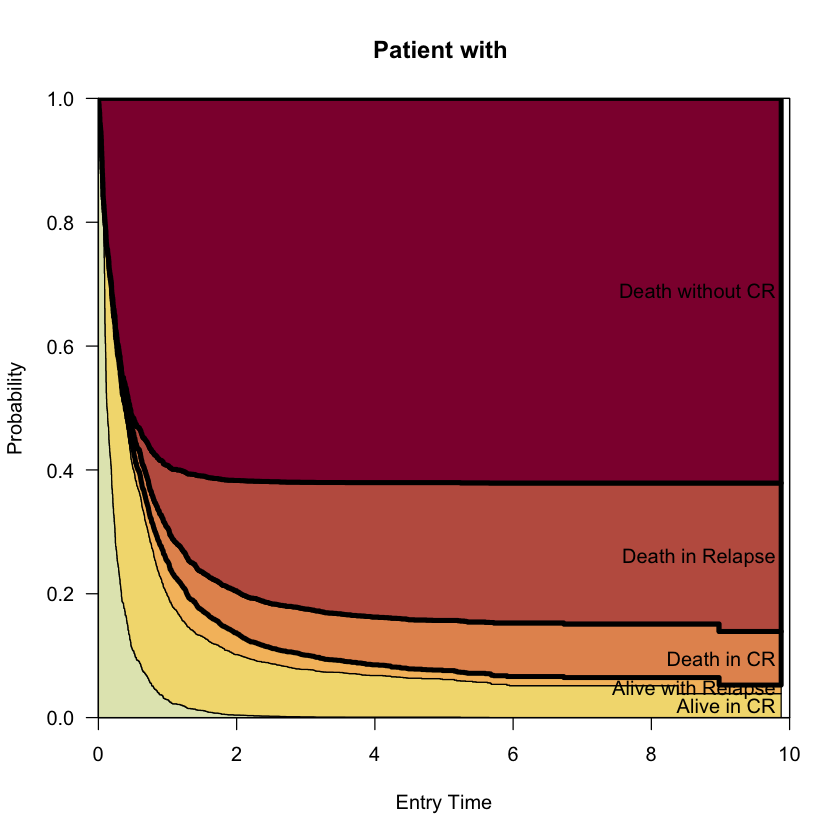

In [15]:

cfull <- coxph(Surv(Tstart, Tstop, status) ~ age.1 + age.2 + age.3 + age.4 + age.5 + strata(trans), data = msdata, method = "breslow")

tmp_data <- rbind(msdata,rep( NA, ncol( msdata ) ))
tmp_data[nrow(tmp_data),c("age","gender")] <- c(85,1)
patA <- tmp_data[rep(nrow(tmp_data),each=5),demo]
patA$trans <- 1:5
attr(patA, "trans") <- tmat_data

patA <- expand.covs(patA, demo, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(cfull, patA, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

plot(ptA, ord = c(1,2,3,4,5,6), main = "Patient with ",
las = 1, xlab = "Entry Time", xlim = c(0, 10),
type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))



In [144]:
patA

,age,gender,trans,gender.1,gender.2,gender.3,gender.4,gender.5,age.1,age.2,age.3,age.4,age.5,strata
7904,85,0,1,0,0,0,0,0,85,0,0,0,0,1
7904.1,85,0,2,0,0,0,0,0,0,85,0,0,0,2
7904.2,85,0,3,0,0,0,0,0,0,0,85,0,0,3
7904.3,85,0,4,0,0,0,0,0,0,0,0,85,0,4
7904.4,85,0,5,0,0,0,0,0,0,0,0,0,85,5


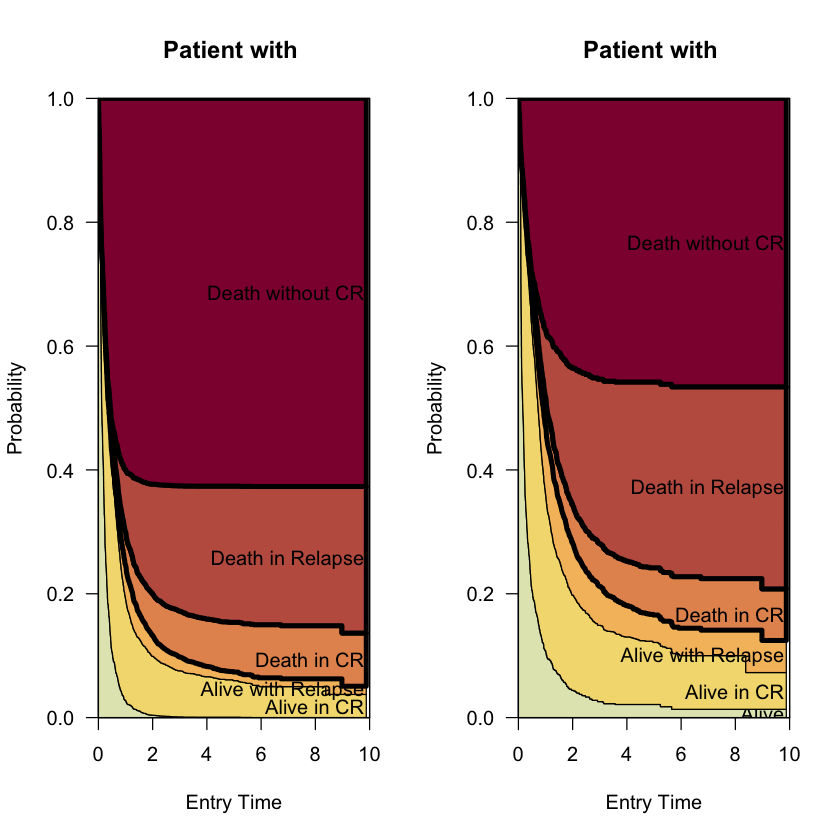

In [122]:
par(mfrow = c(1,2))
cfull <- coxph(Surv(Tstart, Tstop, status) ~ age.1 + age.2 + age.3 + age.4 + age.5 + strata(trans), data = msdata, method = "breslow")
whA <- which(msdata$age >85 & msdata$age <87)
patA <- msdata[rep(whA[1], each=5), demo]
patA$trans <- 1:5
attr(patA, "trans") <- tmat_data
patA <- expand.covs(patA, demo, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(cfull, patA, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

plot(ptA, ord = c(1,2,3,4,5,6), main = "Patient with ",
las = 1, xlab = "Entry Time", xlim = c(0, 10),
type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))

form <- paste("Surv(Tstart, Tstop, status) ~ " , expanded_component[1] , sep="")
for (co in c(expanded_component[2:length(expanded_component)])){#,expanded_genes,expanded_cytos,expanded_demo)) {
    form <- paste (form,co,sep = " + ")
}
form <- paste(form,"+ strata(trans)")
cfull <- coxph(as.formula(form), data = msdata, method = "breslow")
whA <- which(msdata$age >85 & msdata$age <87)
patA <- msdata[rep(whA[1], each=5), comp]
patA$trans <- 1:5
attr(patA, "trans") <- tmat_data
patA <- expand.covs(patA, comp, longnames = FALSE)
patA$strata <- patA$trans
msfA <- msfit(cfull, patA, trans = tmat_data)

ptA <- probtrans(msfA, predt = 0)
ord <- c(1,2,3,4,5,6)

plot(ptA, ord = c(1,2,3,4,5,6), main = "Patient with ",
las = 1, xlab = "Entry Time", xlim = c(0, 10),
type = "filled", col = statecols[ord],lty=c(2,2,2,2,2,2),lwd=c(1,1,1,4,4,4,1,1,1))

In [1]:
patA

ERROR: Error in eval(expr, envir, enclos): object 'patA' not found
